# NLP and the Pipeline

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    NLP and the Pipeline
Author:   R.C. Alvarado
Date:     5 February 2023
```

**Purpose**:  We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.

# Set Up

## Config

To install plotly_express with conda:

```bash
conda install plotly::plotly_express 
```

In [7]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px

In [8]:
import configparser
config = configparser.ConfigParser()
config.read("../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [9]:
source_files = f'{data_home}/austen-melville-set'
data_prefix = 'austen-melville'

In [10]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [11]:
import sys
#sys.path.append(local_lib)

In [12]:
from lib.textparser import TextParser

# Inspect

Since Project Gutenberg texts vary widely in their markup, we define our chunking patterns by hand.

In [13]:
clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (158,   rf"^\s*CHAPTER\s+{roman}\s*$"),
    (946,   rf"^\s*{roman}\s*$"),
    (1212,  rf"^\s*LETTER .* to .*$"),
    (141,   rf"^CHAPTER\s+{roman}$"),
    (121,   rf"^CHAPTER\s+\d+$"),
    (105,   rf"^Chapter\s+\d+$"),
    (1342,  rf"^Chapter\s+\d+$"),
    (161,   rf"^CHAPTER\s+\d+$"),    
    (15422, rf"^\s*CHAPTER\s+{roman}\."),
    (13720, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (13721, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (2701,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"),
    (4045,  rf"^\s*CHAPTER\s+{roman}\.\s*$"),
    (34970, rf"^\s*{roman}\.\s*$"),
    (8118,  rf"^\s*{roman}\. .*$"),
    (21816, rf"^CHAPTER\s+{roman}\.?$"),
    (15859, rf"^\s*[A-Z,;-]+\.\s*$"),
    (1900,  rf"^CHAPTER "),
    (10712, rf"^CHAPTER\s+{roman}\.\s*$")
]

# Register

We get each file and add to a library `LIB`.

In [14]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [15]:
# source_file_list

In [16]:
book_data = []
for source_file_path in source_file_list:
    book_id = int(source_file_path.split('-')[-1].split('.')[0].replace('pg',''))
    book_title = source_file_path.split('/')[-1].split('-')[0].replace('_', ' ')
    book_data.append((book_id, source_file_path, book_title))

In [17]:
LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
    .set_index('book_id').sort_index()

In [18]:
LIB

,source_file_path,raw_title
book_id,,
105,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE PERSUASION
121,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE NORTHANGER ABBEY
141,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE MANSFIELD PARK
158,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE EMMA
161,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE SENSE AND SENSIBILITY
946,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE LADY SUSAN
1212,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE LOVE AND FREINDSHIP SIC
1342,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,AUSTEN JANE PRIDE AND PREJUDICE
1900,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,MELVILLE HERMAN TYPEE A ROMANCE OF THE SOUTH SEAS


In [19]:
try:
    LIB['author'] = LIB.raw_title.apply(lambda x: ', '.join(x.split()[:2]))
    LIB['title'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[2:]))
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass

In [20]:
LIB

,source_file_path,author,title
book_id,,,
105,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PERSUASION
121,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",NORTHANGER ABBEY
141,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",MANSFIELD PARK
158,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",EMMA
161,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",SENSE AND SENSIBILITY
946,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LADY SUSAN
1212,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC
1342,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PRIDE AND PREJUDICE
1900,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",TYPEE A ROMANCE OF THE SOUTH SEAS


## Save Chapter regexes

In [21]:
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))

In [22]:
LIB

,source_file_path,author,title,chap_regex
book_id,,,,
105,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$
121,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$
141,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$
158,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$
161,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$
946,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$
1212,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$
1342,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$
1900,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",TYPEE A ROMANCE OF THE SOUTH SEAS,^CHAPTER


## Tokenize Corpus

We tokenize each book and add each `TOKENS` table to a list to be concatenated into a single `CORPUS`.

In [23]:
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [24]:
LIB.loc[15859].chap_regex

'^\\s*[A-Z,;-]+\\.\\s*$'

In [25]:
CORPUS = tokenize_collection(LIB)

Tokenizing 105 PERSUASION
Importing  /Users/michaelvaden/GithubRepos/DS5001-Workplace/data/austen-melville-set/AUSTEN_JANE_PERSUASION-pg105.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^Chapter\s+\d+$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model


Tokenizing 121 NORTHANGER ABBEY
Importing  /Users/michaelvaden/GithubRepos/DS5001-Workplace/data/austen-melville-set/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^CHAPTER\s+\d+$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 141 MANSFIELD PARK
Importing  /Users/michaelvaden/GithubRepos/DS5001-Workplace/data/austen-melville-set/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^CHAPTER\s+[IVXLCM]+$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 158 EMMA
Importing  /Users/michaelvaden/GithubRepos/DS5001-Workplace/data/austen-melville-set/AUSTEN_JANE_EMMA-pg158.txt
Clipping text
Parsing OHCO

## Extract some features for `LIB`

In [26]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [27]:
LIB.sort_values('book_len')

,source_file_path,author,title,chap_regex,book_len
book_id,,,,,
946,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116
1212,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265
15422,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",ISRAEL POTTER HIS FIFTY YEARS OF EXILE,^\s*CHAPTER\s+[IVXLCM]+\.,65516
15859,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",THE PIAZZA TALES,"^\s*[A-Z,;-]+\.\s*$",75491
121,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601
105,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624
21816,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",THE CONFIDENCE MAN HIS MASQUERADE,^CHAPTER\s+[IVXLCM]+\.?$,95315
13720,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",MARDI AND A VOYAGE THITHER VOL I,^\s*CHAPTER\s+[IVXLCM]+\s*$,96878
13721,/Users/michaelvaden/GithubRepos/DS5001-Workpla...,"MELVILLE, HERMAN",MARDI AND A VOYAGE THITHER VOL II,^\s*CHAPTER\s+[IVXLCM]+\s*$,102092


In [28]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

# Explore

In [29]:
px.scatter(LIB, 'n_chaps', 'book_len', 
           color='author', text='n_chaps', size='book_len', 
           hover_name='title', width=800, height=500) 

In [30]:
LIB.groupby('author')[['book_len', 'n_chaps']].agg(('mean','sum'))

book_len             n_chaps     
                           mean      sum       mean  sum
author                                                  
AUSTEN, JANE       97613.625000   780909  41.750000  334
MELVILLE, HERMAN  116252.545455  1278778  77.363636  851

# Exract VOCAB

Extract a vocabulary from the CORPUS as a whole

## Handle Anomalies

NLTK's POS tagger is not perfect -- note the classification of punctuation as nouns, verbs, etc. We remove these from our corups.

In [31]:
CORPUS[CORPUS.term_str == '']

pos_tuple  pos token_str term_str
book_id chap_id para_num sent_num token_num                                  
105     3       1        5        12         (", NNP)  NNP         "         
                17       6        22         (", VBZ)  VBZ         "         
        6       27       5        0          (),, NN)   NN        ),         
        14      8        1        9          (", VBP)  VBP         "         
        20      8        4        14          (", VB)   VB         "         
...                                               ...  ...       ...      ...
34970   79      12       0        1           (&, CC)   CC         &         
        80      9        0        4          (_., NN)   NN        _.         
        83      8        2        0          (),, NN)   NN        ),         
                         3        0          ();, NN)   NN        );         
        111     5        0        3           (&, CC)   CC         &         

[729 rows x 4 columns]

In [32]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

*        359
"        225
|         85
&          9
*****      7
),         5
."         4
+          4
'          3
"...       2
.'         2
?"         2
"*         2
,"         2
!"         1
[*         1
_.         1
".         1
";         1
*"         1
",         1
....       1
::         1
'_         1
_          1
£          1
&.         1
'"         1
'*         1
***        1
,'         1
);         1
Name: token_str, dtype: int64

In [33]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [34]:
CORPUS['pos_group'] = CORPUS.pos.str[:2]

In [35]:
CORPUS

pos_tuple  ... pos_group
book_id chap_id para_num sent_num token_num                       ...          
105     1       1        0        0                   (Sir, NNP)  ...        NN
                                  1                (Walter, NNP)  ...        NN
                                  2               (Elliot,, NNP)  ...        NN
                                  3                     (of, IN)  ...        IN
                                  4              (Kellynch, NNP)  ...        NN
...                                                          ...  ...       ...
34970   114     24       0        6                    (The, DT)  ...        DT
                                  7          (Ambiguities,, NNP)  ...        NN
                                  8                     (by, IN)  ...        IN
                                  9                (Herman, NNP)  ...        NN
                                  10             (Melville, NNP)  ...        NN

[2059272 rows x 5 columns]

In [36]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

In [37]:
VOCAB

,n,n_chars,p,i
term_str,,,,
0,2,1,9.713651e-07,19.973483
1,23,1,1.117070e-05,16.449921
10,6,2,2.914095e-06,18.388520
100,2,3,9.713651e-07,19.973483
1000,2,4,9.713651e-07,19.973483
...,...,...,...,...
æneas,1,5,4.856826e-07,20.973483
æniad,1,5,4.856826e-07,20.973483
æson,2,4,9.713651e-07,19.973483


# Annotate VOCAB

## Get Max POS

Get the most frequently associated part-of-speech category for each word.

In [38]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [39]:
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

## Compute POS ambiguity

How many POS categories are associated with each word?

In [40]:
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))

In [41]:
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [42]:
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,,,,
0,2,1,9.713651e-07,19.973483,CD,CD,1,{CD},1,{CD}
1,23,1,1.117070e-05,16.449921,CD,CD,2,"{CD, NN}",3,"{CD, NNP, NN}"
10,6,2,2.914095e-06,18.388520,CD,CD,1,{CD},1,{CD}
100,2,3,9.713651e-07,19.973483,CD,CD,1,{CD},1,{CD}
1000,2,4,9.713651e-07,19.973483,CD,CD,1,{CD},1,{CD}
...,...,...,...,...,...,...,...,...,...,...
æneas,1,5,4.856826e-07,20.973483,NN,NN,1,{NN},1,{NN}
æniad,1,5,4.856826e-07,20.973483,NN,NN,1,{NN},1,{NN}
æson,2,4,9.713651e-07,19.973483,NN,NN,1,{NN},1,{NN}


In [43]:
# nltk.help.upenn_tagset()

## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [44]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [45]:
# sw.sample(10)

In [46]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [47]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop
term_str,,,,,,,,,,,
having,1372,6,6.663565e-04,10.551418,VBG,VB,2,"{NN, VB}",5,"{VBD, VBG, NN, VBP, NNP}",1
than,3929,4,1.908247e-03,9.033537,IN,IN,3,"{IN, NN, VB}",7,"{VBZ, VBD, IN, NNS, VB, NN, NNP}",1
for,16655,3,8.089043e-03,6.949815,IN,IN,9,"{JJ, CC, IN, RB, PR, VB, NN, CD, PO}",17,"{JJ, VBD, IN, VBZ, VBN, PRP, CC, RB, RBR, NNS,...",1
ve,2,2,9.713651e-07,19.973483,NN,NN,1,{NN},2,"{NNP, NN}",1
myself,1220,6,5.925327e-04,10.720818,PRP,PR,8,"{JJ, CC, IN, PD, RB, PR, VB, NN}",14,"{JJ, VBZ, PRP, VBD, CC, IN, JJS, RB, PDT, NNS,...",1
who,4564,3,2.216655e-03,8.817400,WP,WP,11,"{JJ, CC, IN, RB, WD, VB, WR, NN, CD, PO, WP}",17,"{WRB, JJ, VBD, VBZ, IN, VBN, CC, RB, NNS, VB, ...",1
under,1271,5,6.173025e-04,10.661735,IN,IN,5,"{JJ, IN, RP, VB, NN}",6,"{JJ, IN, RP, NN, VBP, NNP}",1
each,972,4,4.720835e-04,11.048670,DT,DT,4,"{DT, NN, JJ, VB}",9,"{JJ, VBZ, VBD, NNS, VB, DT, NN, VBP, NNP}",1
yours,231,5,1.121927e-04,13.121734,NN,NN,9,"{JJ, CC, RB, RP, PR, VB, NN, FW, CD}",14,"{JJ, VBZ, PRP, CC, PRP$, RB, RP, NNS, VB, NN, ...",1


## Interlude: Stopword Stats

In [48]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [49]:
pd.concat([a,b], axis=1)

,n_chars,n_pos
stop,,
0,7.871170,2.138943
1,3.766423,12.416058


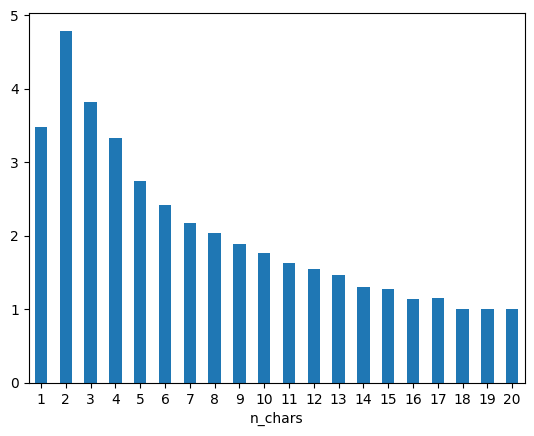

In [50]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_index().plot.bar(rot=0);

Curious that stopwords would have such variability.

In [51]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
you,25,"{CC, VBZ, PRP, PDT, RBR, PRP$, NNS, MD, CD, RB..."
now,22,"{CC, VBZ, PDT, RBR, PRP, NNS, MD, CD, RB, RP, ..."
me,22,"{VBZ, PDT, PRP, CC, RBR, NNS, MD, CD, JJS, RB,..."
that,21,"{VBZ, PDT, PRP, CC, NNS, RB, RP, VBG, VB, WDT,..."
here,21,"{VBZ, PDT, PRP, PRP$, CC, NNS, MD, CD, RB, VB,..."
there,20,"{VBZ, PDT, NNS, MD, CD, RB, RP, VBG, VB, WDT, ..."
not,20,"{VBZ, CC, PRP, PDT, NNS, MD, CD, RB, RP, VB, F..."
this,20,"{PDT, VBZ, PRP, NNS, CD, RB, RP, VBG, VB, POS,..."
more,20,"{VBZ, PDT, PRP, RBR, CC, NNS, MD, JJS, RB, VBG..."


Anyway, let's compare stopword usage across authors.

In [52]:
X = CORPUS.merge(LIB.reset_index()[['book_id','author']], on='book_id')\
    .merge(VOCAB.reset_index()[['term_str', 'stop']], on='term_str')\
    .groupby(['author','stop']).agg('sum', numeric_only=True).unstack()
X.columns = X.columns.droplevel(0)

In [53]:
(X.T / X.T.sum()).T.style.background_gradient(axis=None)

stop,0,1
author,,
"AUSTEN, JANE",0.451550,0.548450
"MELVILLE, HERMAN",0.508578,0.491422


## Add Stems

In [54]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [55]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,
eyeballs,3,8,1.457048e-06,19.388520,NNS,NN,1,{NN},1,{NNS},0,eyebal,eyebal,eyebal
perambulated,1,12,4.856826e-07,20.973483,VBD,VB,1,{VB},1,{VBD},0,perambul,perambul,peramb
rammers,3,7,1.457048e-06,19.388520,NNS,NN,1,{NN},2,"{NN, NNS}",0,rammer,rammer,ram
dozers,1,6,4.856826e-07,20.973483,NNS,NN,1,{NN},1,{NNS},0,dozer,dozer,doz
courtships,2,10,9.713651e-07,19.973483,NNS,NN,1,{NN},1,{NNS},0,courtship,courtship,court
drenched,10,8,4.856826e-06,17.651555,VBN,VB,2,"{JJ, VB}",3,"{VBD, VBN, JJ}",0,drench,drench,drench
owens,5,5,2.428413e-06,18.651555,NNP,NN,1,{NN},1,{NNP},0,owen,owen,ow
uneventfulness,1,14,4.856826e-07,20.973483,JJ,JJ,1,{JJ},1,{JJ},0,unev,unev,unev
pastures,20,8,9.713651e-06,16.651555,NN,NN,2,"{NN, VB}",3,"{VBZ, NN, NNS}",0,pastur,pastur,past


In [56]:
VOCAB[VOCAB.stem_porter != VOCAB.stem_snowball]

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,
abandonedly,2,11,9.713651e-07,19.973483,RB,RB,1,{RB},1,{RB},0,abandonedli,abandon,abandon
abhorringly,1,11,4.856826e-07,20.973483,RB,RB,1,{RB},1,{RB},0,abhorringli,abhor,abhor
abjectly,2,8,9.713651e-07,19.973483,RB,RB,1,{RB},1,{RB},0,abjectli,abject,abject
abjectus,1,8,4.856826e-07,20.973483,NNP,NN,1,{NN},1,{NNP},0,abjectu,abjectus,abject
aboundingly,1,11,4.856826e-07,20.973483,RB,RB,1,{RB},1,{RB},0,aboundingli,abound,abound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yes,945,3,4.589700e-04,11.089312,NN,NN,12,"{JJ, CC, IN, RB, RP, PR, VB, NN, CD, PO, UH, FW}",20,"{VBZ, PRP$, PRP, CC, NNS, CD, RB, RP, VB, POS,...",0,ye,yes,ye
yous,1,4,4.856826e-07,20.973483,NN,NN,1,{NN},1,{NN},0,you,yous,yo
yrs,4,3,1.942730e-06,18.973483,NNP,NN,1,{NN},2,"{NNP, NN}",0,yr,yrs,yr


# Save

In [57]:
out_path = f'{output_dir}/{data_prefix}'

In [58]:
LIB.to_csv(f'{out_path}-LIB.csv')
VOCAB.to_csv(f'{out_path}-VOCAB.csv')
CORPUS.to_csv(f'{out_path}-CORPUS.csv')